<a href="https://colab.research.google.com/github/JeanCarloBejaran/Marketing-Campaign/blob/master/Marketing_Data_Analysis_Commit2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Work-Plan
Answer these questions on the blog posts. Three: (1-3) (4-6) (7-8)

1. Frame the problem - Look at big picture

2. Get the Data

3. Explore, gain insights

4. Prepare data to better expose the underlying patterns to ML Algorithms.

5. Explore models and short-list the best ones.

6. Fine tune models and combine them into a great solution.

7. Present your solution.

8. Launch, monitor and mantain your system.



# Assignment:

1. Explore Business to report insights on Business Operations and product-market fit.
2. Make a report communicating findings relevant to the business's health and any Machine Learning opportunities.

# Possible solutions
- A Customer behavior forecasting tool to inform our strategy around customer relationships and channels of engagement. 
- A dashboard allowing intuitive market and business exploration.

(Assumption: I sorted data on Dt_Customer to simulate new data.)


In [0]:
import math, datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno
import seaborn as sns

sns.set()

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

#Plot figures inline
#%matplotlib inline

In [369]:
#Get the data


raw_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Datasets/marketing_campaign.csv', sep = ';')

#Clean for relevant data
drop_columns = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp2', 'AcceptedCmp1', 'Z_CostContact','Z_Revenue', 'Response']
Customers = raw_data.drop(drop_columns, axis = 1)

#Order data based on date of enrollment
Customers.sort_values('Dt_Customer')
#Customers.set_index('ID', inplace = True)

Full_Dataset_len = len(Customers)
Full_Dataset_len


2240

## ${\textbf{Split out the test set}}$

In [370]:
#To simulate new customers,  remove the last 10 percent of customers to sign up.
Customers_indeces = int(len(Customers)*0.9)
New_Customers = Customers.iloc[Customers_indeces:]
Customers = Customers.iloc[:Customers_indeces]

#Test that we succesfully split the data
assert len(New_Customers) + len(Customers) == Full_Dataset_len
print(len(Customers), len(New_Customers))

2016 224


# ${\textbf{Part 1: Exploratory Data Analysis}}$

Explore Market Analysis and Business Analysis Individually. Then explore joint analysis possibilities. 

**Strategy**:
Clean and validate data: Explore each feature for missing values, find possible noise, rounding errors, etc.

Study each feature. 

What feature Engineering can we do to better display the important patterns?

## ${\textbf{Market Analysis}}$

Who are our Customers?

Assuming: Customers provide the signup features information through a form as they become members.

Signup_features = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer']

In [371]:
Customers.describe()

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain
count,2016.000000,2016.000000,1999.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000,2016.000000
mean,5589.754960,1968.850198,52109.370185,0.443452,0.500992,49.213790,305.908234,26.371528,168.003968,37.687996,27.555060,43.665179,2.320437,4.079861,2.687996,5.815972,5.310516,0.009921
std,3242.224842,11.992900,21489.215163,0.539991,0.545679,28.960372,338.171717,39.889915,225.793019,54.745578,41.878567,51.617293,1.954444,2.775660,2.955144,3.255438,2.450666,0.099132
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2859.000000,1959.000000,35533.500000,0.000000,0.000000,24.000000,24.000000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000
50%,5454.000000,1970.000000,51412.000000,0.000000,0.000000,50.000000,176.500000,8.000000,68.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000
75%,8418.500000,1977.000000,68656.000000,1.000000,1.000000,74.000000,499.750000,33.000000,235.500000,50.000000,34.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000
max,11191.000000,1996.000000,162397.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000


In [372]:
#categorical features
Customers.describe(include = ['O'])

,Education,Marital_Status,Dt_Customer
count,2016,2016,2016
unique,5,6,651
top,Graduation,Married,2012-08-31
freq,1002,772,12


In [373]:
Customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2016 non-null   int64  
 1   Year_Birth           2016 non-null   int64  
 2   Education            2016 non-null   object 
 3   Marital_Status       2016 non-null   object 
 4   Income               1999 non-null   float64
 5   Kidhome              2016 non-null   int64  
 6   Teenhome             2016 non-null   int64  
 7   Dt_Customer          2016 non-null   object 
 8   Recency              2016 non-null   int64  
 9   MntWines             2016 non-null   int64  
 10  MntFruits            2016 non-null   int64  
 11  MntMeatProducts      2016 non-null   int64  
 12  MntFishProducts      2016 non-null   int64  
 13  MntSweetProducts     2016 non-null   int64  
 14  MntGoldProds         2016 non-null   int64  
 15  NumDealsPurchases    2016 non-null   i

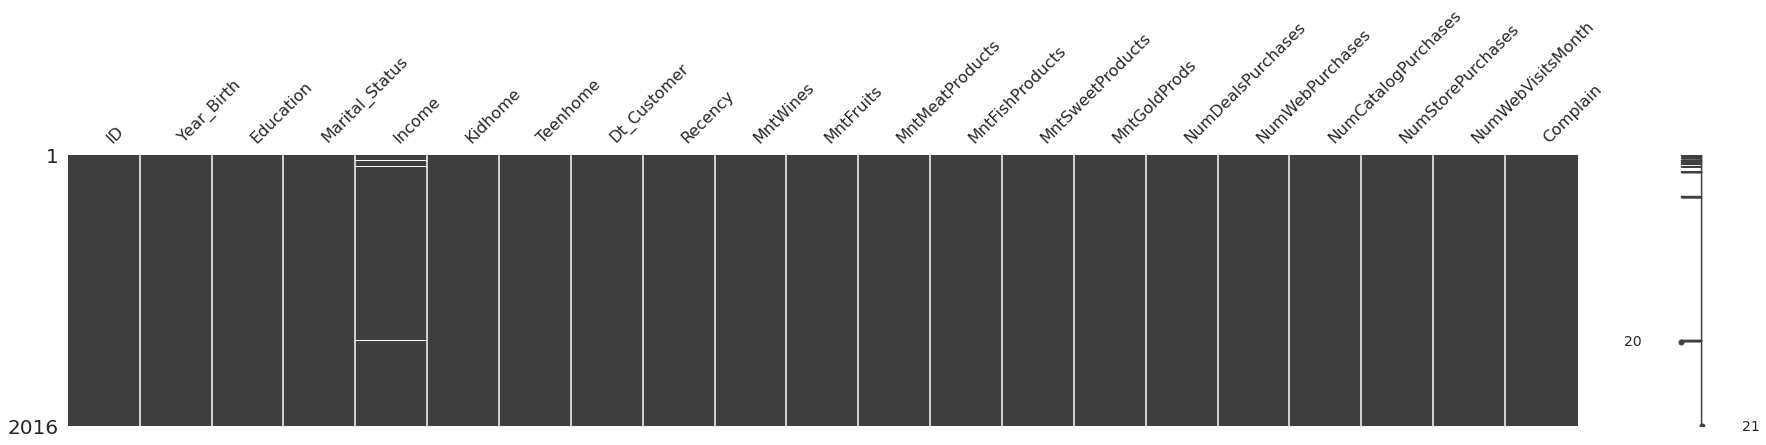

In [374]:
#Checking null values
missingno.matrix(Customers, figsize = (30,5))

In [375]:
#Missing income check
Miss_Income_Customers = Customers[Customers.Income.isna()]
len(Miss_Income_Customers)


17

The null income customers don't appear to have any statistically significant differences from the rest of the data at a first glance.



In [0]:
#Drop the 17 null values
Customers.dropna(inplace = True)
assert len(Customers) == Full_Dataset_len - len(New_Customers) - len(Miss_Income_Customers)


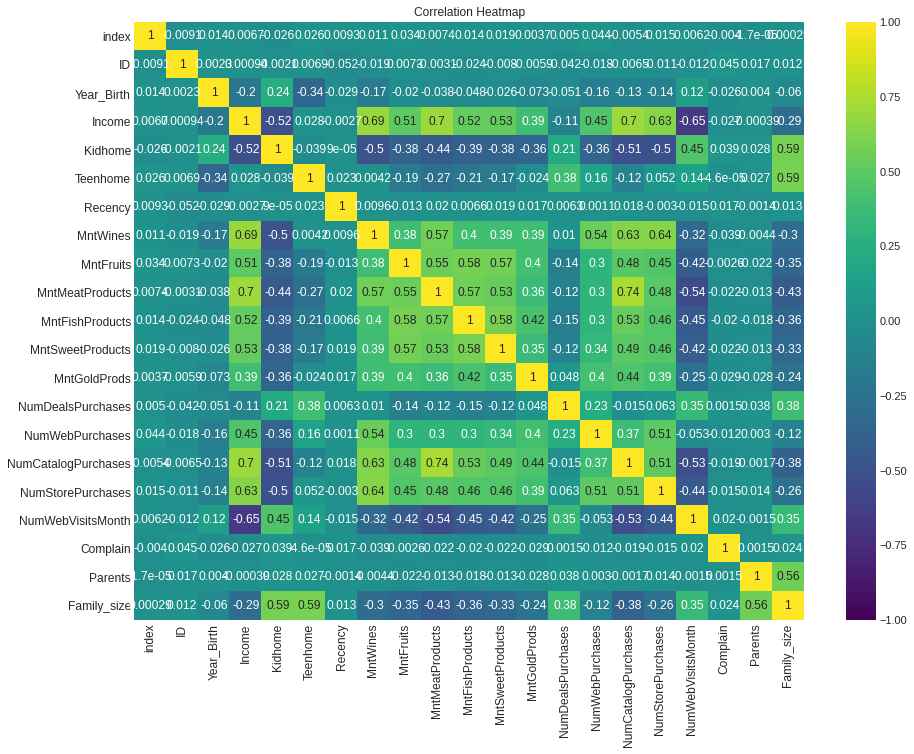

In [456]:
#Quick data overview through a feature correlation heatmap
plt.figure(figsize = (15,11))
s = sns.heatmap(Customers.reset_index().corr(),
               annot = True, 
               cmap = 'viridis',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

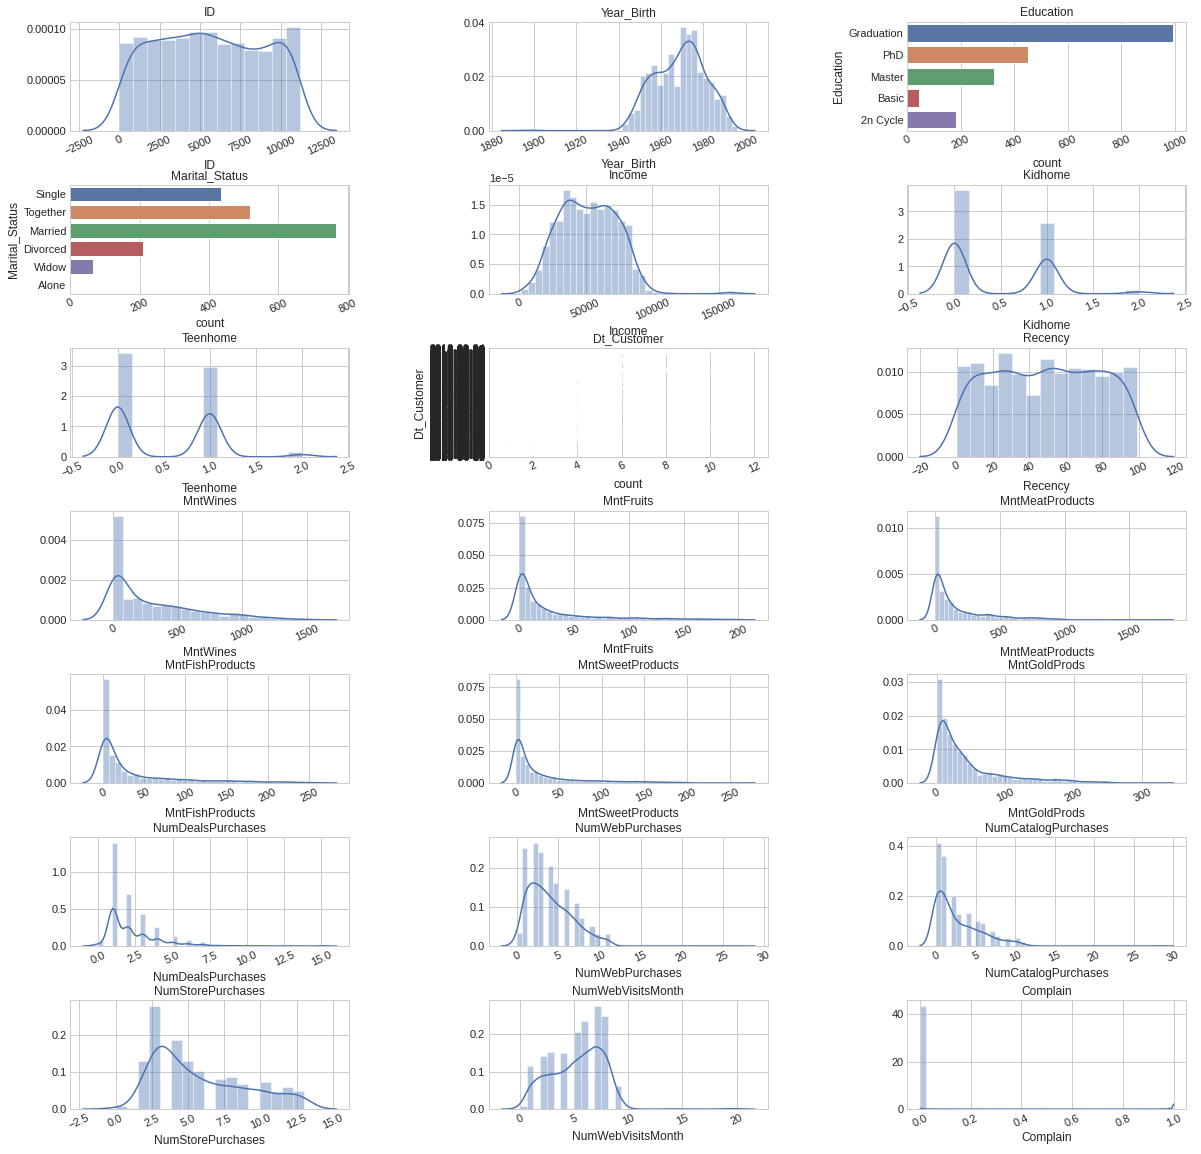

In [379]:
#plot distribution of each numerical and categorical variables
def plot_distribution(dataset = Customers, cols=17, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)
    
plot_distribution(Customers, cols=3, width=20, height=20, hspace=0.5, wspace=0.5)

Exploration on Household: Number of dependents, Teenagers or kids, Household size.

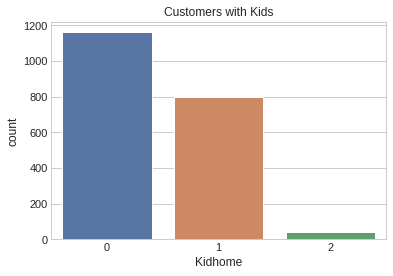

In [459]:
#Amount of kids
sns.countplot(x = 'Kidhome' , data = Customers)
plt.title('Customers with Kids')
plt.show()

#How many of our Customers have teenagers?


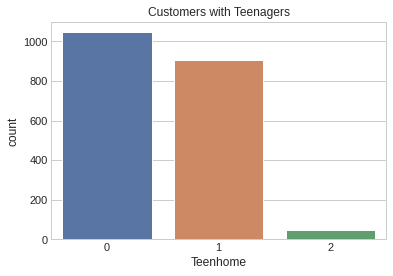

In [460]:
#amount of teenagers
sns.countplot(x = 'Teenhome' , data = Customers)
plt.title('Customers with Teenagers')
plt.show()

#Feature Engineering: Household size


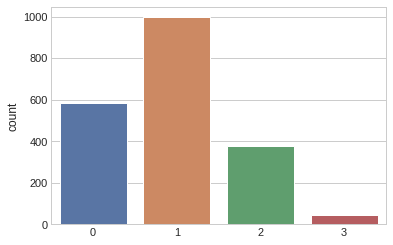

In [461]:
#number of dependants
Num_dependants = Customers.Kidhome + Customers.Teenhome
sns.countplot(Num_dependants)
plt.show()

In [384]:
#has_partner = list(Customers.query("Marital_Status == 'Together'").ID) + list(Customers.query("Marital_Status == 'Married'").ID) 

Customers['Parents'] = Customers.Marital_Status.replace({"Together": 2,
                                                       "Married": 2,
                                                       "Single": 1,
                                                       "Divorced": 1,
                                                       "Widow": 1,
                                                       'Alone': 1})

Customers['Family_size'] = Customers.Teenhome + Customers.Kidhome + Customers.Parents
Customers

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Parents,Family_size
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,1,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,1,3
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,2,2
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,2,3
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,3657,1986,Graduation,Single,39146.0,1,0,2013-02-14,1,94,1,33,13,12,12,3,4,0,4,8,0,1,2
2012,500,1977,Graduation,Together,96876.0,0,0,2013-08-06,79,908,43,735,40,194,21,1,7,7,9,2,0,2,2
2013,1951,1981,Basic,Married,34445.0,0,0,2013-01-27,92,228,122,122,208,129,30,6,11,2,8,9,0,2,2
2014,3262,1958,Graduation,Single,68281.0,0,0,2012-08-07,31,995,112,417,42,48,41,1,2,9,13,5,0,1,1


In [0]:
def label_from_index(pre_label):
  lista = list(pre_label)
  fixed_names = []
  for entry in lista:
    fixed_names.append(str(entry) + str(' members'))
  return fixed_names

In [462]:
plt.pie(Customers.Family_size.value_counts(), labels = label_from_index(Customers.Family_size.value_counts().index))
plt.title('Family Size Distribution')
plt.show()



SyntaxError: ignored

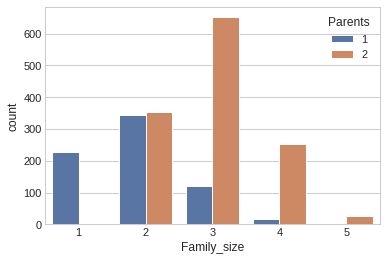

In [466]:
#sns.kdeplot(Customers.Family_size.value_counts())
sns.countplot(Customers.Family_size, hue = Customers.Parents)

#Dt_Customers Exploration

#Recency

#Insights:




## ${\textbf{Business Analysis}}$

1. Revenue: Total and per sector over the last two years
2. Predict Complaining - Is recency related to complaining: how important is complaining / What percentage of Customers who complain recind?
3. What is the mediums our Customers engage with us the most?

Coding tasks:

1. Pie chart or similar of total revenues per sector in past two years.
2. Pie chart or similar of total purchases or sales events in the last two years.
3. How many Web visits per purchase?

Feature Engineering: Test tracking a web_visits per purchase metric and see if it leads anywhere.


In [0]:
#Feature Engineering
#Create a total amount spent per Customer.
Customers['2yr_Spent'] = Customers.MntWines + Customers.MntFruits + Customers.MntMeatProducts + Customers.MntFishProducts + Customers.MntSweetProducts + Customers.MntGoldProds

#Part 2: Machine Learning Notebook
Prepare the Data:



In [0]:
#possible strategies for pipeline:
#Drop missing income values, make missing values a category, use median, use regression function to estimate.
SimpleImputer(strategy = 'constant', fill_value='missing')


#Preprocessing
Customers['Income_missing'] = [1 for income in Customers.Income if Customers.Income == 'missing' else 0]
Customers[Customers.Marital_Status == 'Alone'] = 'Single'
Customers['Education'] = Customers.Education.astype('category')
Customers['Marital_Status'] = Customers.Marital_Status.astype('category')

ohe = OneHotEncoder()
col_transformer = make_column_transformer((ohe, make_column_selector(dtype_include = 'category')))

col_transformer.fit_transform(Customers)

In [0]:
#Explore possible model performance increase by filling income values using a linear regression
#Replace missing vlaues with linear regression using the other features. (Bloggable)
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()


In [0]:
#Find a way to rank features to answer the best questions:

#Possible value generatable with this data:
  #Cluster clients to decide our development strategy for the future based on new registrations. (K-Means)
    #Use incoming registration data to deploy model that: (In a business scenario, I would prioritize focus by asking internal client)
      # Predict amount spent on group of goods over next 2 years. (2-year-value)
      # Predict platform interaction behavior (NumWebVisits)
      # Predict if the new customers will complain? Why? How much are we losing because they will?

In [0]:
# (Possible) Deploy the new customers test data to a csv on github (using it as a database) to access and assess our predictions to practice webscraping Using requests (r = requests.get(url); df = pd.read_html(r.text); return df[0] )

# Part 3: Part App Building and Deployment Notebook
  -Deploy model to Heroku in a flask app that takes in a csv of new customers and returns a dashboard with the predictions for the next 2-year value. 